## Simulating any compartmental model with testing and quarantine using the `SppQ` class



In [1]:
%matplotlib inline
import numpy as np
import pyross
import matplotlib.pyplot as plt
#from matplotlib import rc; rc('text', usetex=True)

### The SIR model with quarantine

Below you will find the model-specification dictionary for the SIR model with quarantined states

In [2]:
model_spec = {
    "classes" : ["S", "I"],

    "S" : {
        "infection" : [ ["I", "-beta"] ],
    },

    "I" : {
        "linear"    : [ ["I", "-gamma"] ],
        "infection" : [ ["I", "beta"] ],
    },
    
    #                S              I           R
    "test_pos"  : [ "p_falsepos", "p_truepos", "p_falsepos"] ,
    "test_freq" : [ "pi_RS",      "pi_I",      "pi_RS"] 
}

parameters = {
    'beta' : 0.02,
    'gamma' : 0.1, 
    'p_falsepos' : 0.01,
    'p_truepos'  : 0.9,
    'pi_RS'      : 0.1,
    'pi_I'      : 1
    
}

This corresponds to

$$
\begin{aligned}
\dot{S}_i & =  - \beta \sum_j C_{ij} \frac{I_j}{N_j} S_i - \tau_S S_i; &\dot{S}^Q_i & =  \tau_S S_i \\
\dot{I}_i & = \beta \sum_j C_{ij} \frac{I_j}{N_j} S_i - \gamma I_i - \tau_I I_i;
&\dot{I}^Q_i & =- \gamma I_i^Q+ \tau_I I_i\\
\dot{R}_i & = \gamma I_i- \tau_R R_i; &\dot{R}^Q_i & = \gamma I^Q_i+ \tau_R R_i;
\end{aligned}
$$

Each of the classes, `S`, `I` and `R`,  have a quarantined version, `SQ`, `IQ` and `RQ`. The dynamics within the quarantined states is the same as for the un-quarantined states, but there are no infection terms (assuming perfect quarantine). Individuals are quarantined upon testing positive, hence the total number $N^Q=S^Q+I^Q+R^Q$ would be the reported number of confirmed cases. 

The transition rates $\tau_S$, $\tau_I$, $\tau_R$ for irreversible transitions to the quarantined states are dependent on time and on other variables. They are determined by the overall testing rate $\tau_{tot}(t)$ and the parameters specified in `"test_pos"` and `"test_prob"` (ordered such that they match to `S`, `I` and `R`).  

- `"test_pos"` specifies the probability $\kappa_S$, $\kappa_I$, $\kappa_R$ that a test performed on an individual of a given class is positive. For classes $R$ and $S$, this is the conditional probability of false positives, for class $I$ the conditional probability of a true positive

- `"test_freq"` characterises the frequency $\pi_S$, $\pi_I$, $\pi_R$ of tests in a given class. The absolute values of these values does not matter, only their relative magnitudes. If we consider symptomatic testing and set $\pi_I=1$, then $\pi_R=\pi_S$ is the fraction of people who would like to be tested because of symptoms of flu or cold among the population *not* infected with SARS-CoV-2. In models with several infected classes, this parameter can also be used to prioritise testing of patients with severe symptoms or elderly people

- The rate of positive tests in each class is computed as
  $$ \tau_X=\tau_{tot}(t)\pi_X \kappa_X/\mathcal{N} $$
  for $X\in\{S,I,R\}$ with the normalisation constant
  $$ \mathcal{N}=\sum_X \pi_X  X$$

Next, we define the initial condition for all non-quarantined and quarantined states. $R$ is never specified but calculated from the total number. The initial value for $N^Q$ is specified for the auxiliary class `NiQ`. The (scalar) testing rate $\tau_{tot}(t)$ is specified as a Python function, similar to the time dependent contact matrix. Here, we specify a rapid increase from 10 to 100 tests per day around day 40.

In [3]:
M = 2                # the population has two age groups
N = 5e4              # and this is the total population

# set the age structure
fi = np.array([0.25, 0.75])  # fraction of population in age age group
Ni = N*fi

# set the contact structure
CM = np.array([[18., 9.], [3., 12.]])


# Initial conditions as an array
S0 = np.array([Ni[0]-10, Ni[1]-10])
I0 = np.array([10,   10])

x0 = np.array([
    S0[0], S0[1],   # S
    I0[0], I0[1],   # I
    0,   0,     # R
    0,   0,     # SQ
    0,   0,     # IQ
    0,   0      # RQ
])


def contactMatrix(t):  
    return CM

# Tests performed per day
def testRate(t):
    return (900.*(1.+np.tanh((t-30.)/10.))/2.+100.)

# duration of simulation and data file
Tf = 100;  Nf=Tf+1; 

model = pyross.stochastic.SppQ(model_spec, parameters, M, Ni)
data = model.simulate(x0, contactMatrix, testRate, Tf, Nf)
data_array = data['X']

det_model = pyross.deterministic.SppQ(model_spec, parameters, M, Ni)
data_det = det_model.simulate(x0, contactMatrix, testRate, Tf, Nf)
data_array_data = data_det['X']

# non-quarantined version for comarpison
model_specU = model_spec.copy()
model_specU.pop('test_freq')
model_specU.pop('test_pos')
modelU = pyross.stochastic.Spp(model_specU, parameters, M, Ni)
dataU = modelU.simulate(x0[0:(2*M)], contactMatrix, Tf, Nf)

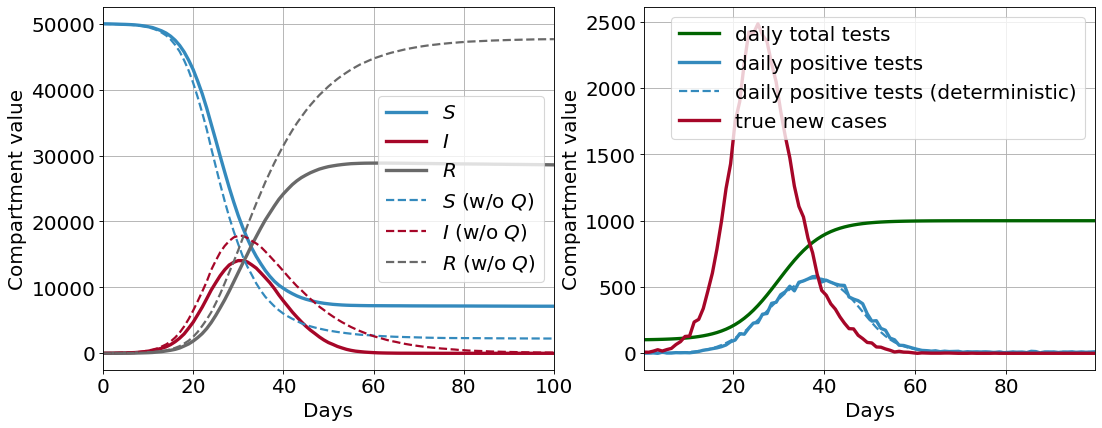

In [4]:
# plot the data and obtain the epidemic curve
S = np.sum(model.model_class_data('S', data), axis=1)
I = np.sum(model.model_class_data('I', data), axis=1)
R = np.sum(model.model_class_data('R', data), axis=1)
SQ = np.sum(model.model_class_data('SQ', data), axis=1)
IQ = np.sum(model.model_class_data('IQ', data), axis=1)
RQ = np.sum(model.model_class_data('RQ', data), axis=1)
NQ = np.sum(model.model_class_data('NiQ', data), axis=1)

NQ_det = np.sum(det_model.model_class_data('NiQ', data_det), axis=1)

SU = np.sum(modelU.model_class_data('S', dataU), axis=1)
IU = np.sum(modelU.model_class_data('I', dataU), axis=1)
RU = np.sum(modelU.model_class_data('R', dataU), axis=1)

t = data['t']

fig = plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 18})

plt.subplot(1, 2, 1)
plt.plot(t, S, '-', color="#348ABD", label='$S$', lw=3)
plt.plot(t, I, '-', color='#A60628', label='$I$', lw=3)
plt.plot(t, R, '-', color="dimgrey", label='$R$', lw=3)
plt.plot(t, SU, '--', color="#348ABD", label='$S$ (w/o $Q$)', lw=2)
plt.plot(t, IU, '--', color='#A60628', label='$I$ (w/o $Q$)', lw=2)
plt.plot(t, RU, '--', color="dimgrey", label='$R$ (w/o $Q$)', lw=2)

plt.legend(fontsize=18); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel('Compartment value')
plt.xlabel('Days');

plt.subplot(1, 2, 2)
tm = t[1:]-0.5
plt.plot(tm, [testRate(tt) for tt in tm], '-', color="darkgreen", label='daily total tests', lw=3)
plt.plot(tm, np.diff(NQ), '-', color="#348ABD", label='daily positive tests', lw=3)
plt.plot(tm, np.diff(NQ_det), '--', color="#348ABD", label='daily positive tests (deterministic)', lw=2)
plt.plot(tm, np.diff(I+R+IQ+RQ), '-', color="#A60628", label='true new cases', lw=3)

plt.legend(fontsize=18); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel('Compartment value')
plt.xlabel('Days');

In this simple model, testing and quarantining has helped to eradicate the disease. It is interesting to evaluate how many infections have been confired anf how many have remained unconfirmed:

In [5]:
print("Confirmed cases:", int(RQ[-1]))
print("Confirmed cases (incl. false positives):", int(NQ[-1]))
print("Total cases:", int(R[-1]+RQ[-1]))

Confirmed cases: 14111
Confirmed cases (incl. false positives): 14270
Total cases: 42701


In [6]:
# load the data and rescale to intensive variables 
Tf_inference = 30 # truncate to only getting the first few datapoints 
Nf_inference = Tf_inference+1
x = (data_array[:Nf_inference]).astype('float')/N

inference_parameters = parameters.copy()

In [7]:
# a filter that sums over all the diagnosed people for each age group
fltr = np.kron([0, 0, 0, 1, 1, 1],np.identity(M))
print(fltr)

# Compare the deterministic trajectory and the stochastic trajectory with the same 
# initial conditions and parameters 
obs=np.einsum('ij,kj->ki', fltr, x)
x0=x[0]

# initialise the estimator 
estimator = pyross.inference.SppQ(model_spec, inference_parameters, testRate, M, fi, Omega=N, lyapunov_method='euler')


# compute -log_p for the original (correct) parameters 
logp = estimator.minus_logp_red(inference_parameters, x0, obs, fltr, Tf_inference, contactMatrix)
print(logp) 

[[0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1.]]
165.07297901646587


In [8]:
x0_old = np.array([
    S0[0], S0[1],   # S
    I0[0], I0[1],   # I
    0,   0,     # SQ
    0,   0,     # IQ
    0,   0      # NiQ
])/N

# a filter that sums over all the diagnosed people for each age group
fltr_old = np.kron([0, 0, 0, 0, 1],np.identity(M))
print(fltr_old)

# initialise the estimator 
estimator_old = pyross.inference.SppQ_old(model_spec, inference_parameters, testRate, M, fi, Omega=N, lyapunov_method='euler')


# compute -log_p for the original (correct) parameters 
logp = estimator_old.minus_logp_red(inference_parameters, x0_old, obs, fltr_old, Tf_inference, contactMatrix)
print(logp) 

[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
165.07397952069124


In [9]:
# make parameter guesses and set up bounds for each parameter 
eps=1e-4
param_priors = {
    'beta':{
        'mean': 0.015, 
        'std': 0.015, 
        'bounds': (eps, 0.1)
    }, 
    'gamma':{
        'mean': 0.08, 
        'std': 0.1, 
        'bounds': (eps, 1)
    }
}

# set up filter for initial conditions because they are constraint by the observed 
# note that this filter is different from the bulk of the trajectory, 
# because we know the initial value 0 holds for R all quarantined age groups
obs0 = np.zeros(M*4)
obs0[:M] = fi
fltr0 = np.kron(([[1, 1, 1, 0, 0, 0],
                  [0, 0, 0, 1, 0, 0],
                  [0, 0, 0, 0, 1, 0],
                  [0, 0, 0, 0, 0, 1]
                 ]), np.identity(M))
init_fltr = np.repeat([True, True, False, False, False, False], M)

full_obs = np.array([obs0, *obs[1:]])
full_fltrs = np.array([fltr0, *([fltr]*(Nf_inference-1))])

I0_g = (I0)/N
I_std = I0_g
bounds_for_I = np.tile([0.1/N, 100/N], M).reshape(M, 2)

S0_g = (S0)/N
S_std = I_std*3 
bounds_for_S = np.array([(1/N, f) for f in fi])

init_priors = {
    'independent':{
        'fltr':init_fltr,
        'mean':[*S0_g, *I0_g], 
        'std': [*S_std, *I_std], 
        'bounds': [*bounds_for_S, *bounds_for_I]
    }
}

# optimisation parameters 
ftol = 1e-5 # the relative tol in (-logp)
res = estimator.latent_infer_parameters(full_obs, full_fltrs, Tf_inference, contactMatrix, 
                                           param_priors, init_priors, 
                                            global_max_iter=30, global_atol=10, 
                                            verbose=True, ftol=ftol) 

Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 6 (seed=3607302177, Thu Sep 17 11:02:08 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 1.324757729129757e+02 1.0e+00 1.19e+00  2e-04  1e-01 0:00.2
    2     32 1.524300397395269e+02 1.4e+00 1.29e+00  3e-04  1e-01 0:00.4
    3     48 1.354807071187979e+02 1.5e+00 1.33e+00  3e-04  1e-01 0:00.6
   17    272 1.332075522081024e+02 5.1e+00 6.11e-01  9e-05  5e-02 0:03.7
Global optimisation: Maximum number of iterations reached.
Optimal value (global minimisation):  130.46021512368327
Starting local minimisation...
Optimal value (local minimisation):  130.38762498216423


In [10]:
print("True parameters:")
print(inference_parameters)

print("\nInferred parameters:")
best_estimates = res['map_params_dict']
print(best_estimates)

print('\n True initial conditions: ') 
print((x0*N).astype('int'))

map_x0 = res['map_x0']
print('\n Inferred initial conditions: ') 
print((map_x0*N).astype('int'))

# compute -log_p for the original (correct) parameters 
logp = estimator.minus_logp_red(inference_parameters, map_x0, obs, fltr, Tf_inference, contactMatrix)
print(logp) 

True parameters:
{'beta': 0.02, 'gamma': 0.1, 'p_falsepos': 0.01, 'p_truepos': 0.9, 'pi_RS': 0.1, 'pi_I': 1}

Inferred parameters:
{'beta': 0.01841346783923304, 'gamma': 0.07393744906380363, 'p_falsepos': 0.01, 'p_truepos': 0.9, 'pi_RS': 0.1, 'pi_I': 1}

 True initial conditions: 
[12490 37490    10    10     0     0     0     0     0     0     0     0]

 Inferred initial conditions: 
[12485 37490     9     9     5     0     0     0     0     0     0     0]
165.07455086874933


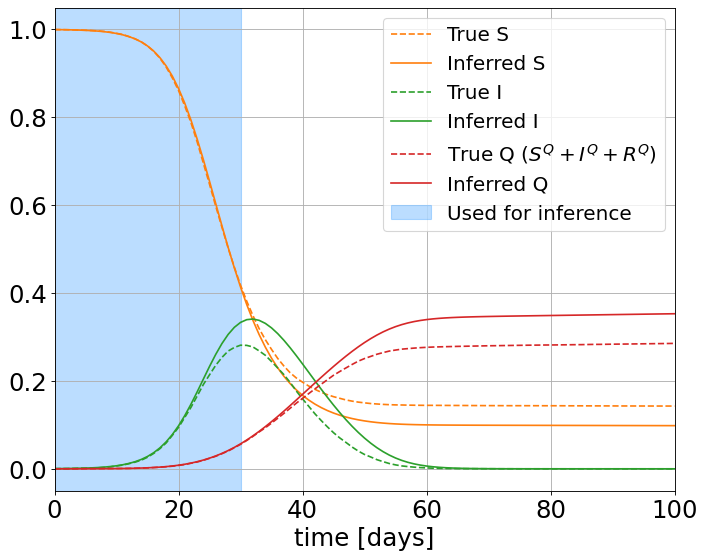

In [11]:
# plot the guessed trajectory and the true trajectory 
estimator.set_params(best_estimates)
estimator.set_det_model(best_estimates)
x_det = estimator.integrate(map_x0, 0, Tf, Nf)

fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})
plt.plot(S/N, label='True S', ls='--', c='C1')
plt.plot(np.sum(x_det[:, 0*M:1*M],axis=1), label='Inferred S', c='C1')
plt.plot(I/N, label='True I', ls='--', c='C2')
plt.plot(np.sum(x_det[:, 1*M:2*M],axis=1), label='Inferred I', c='C2')
plt.plot(NQ/N, label='True Q ($S^Q+I^Q+R^Q$)', ls='--', c='C3')
plt.plot(np.sum(x_det[:, 3*M:6*M],axis=1), label='Inferred Q', c='C3')


plt.axvspan(0, Tf_inference, 
           label='Used for inference',
           alpha=0.3, color='dodgerblue')
plt.xlim([0, Tf])
plt.legend(fontsize=18); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)
plt.xlabel("time [days]")
plt.show()